In [1]:
import torch
import numpy as np
import sys
sys.path.append('/Users/colecitrenbaum/Documents/GPs/gp-quadrature/')
sys.path.append('/Users/colecitrenbaum/Documents/GPs/gp-quadrature/Graveyard/')
import matplotlib.pyplot as plt
import finufft
import time
from efgpnd import compute_gradients_truncated, efgpnd_gradient_batched, compute_gradients_vanilla
from vanilla_gp_sampling import sample_gp_fast, sample_gp_matern
from utils.kernels import get_xis
from kernels.squared_exponential import SquaredExponential
import math
from torch.profiler import profile, record_function, ProfilerActivity
import pytorch_finufft.functional as pff
from typing import Dict, Optional, Callable, Tuple
from cg import ConjugateGradients, BatchConjugateGradients
from typing import Optional, Tuple, Dict
import pytorch_finufft.functional as pff
from cg import ConjugateGradients, BatchConjugateGradients
from efgpnd import ToeplitzND, compute_convolution_vector_vectorized_dD, _cmplx, nufft_var_est_nd, diag_sums_nd, efgp_nd, EFGPND, efgpnd_gradient_batched
import warnings
warnings.filterwarnings("ignore", message=".*disabling cuda.*")


# Sample some data from a GP

In [2]:


# --- Parameters ---
n = 200  # Number of points
d = 2  # Dimensionality of the input space
true_length_scale =0.23
true_variance = 2
true_noise_variance = 0.2
dtype = torch.float64  # Use float64 as in the original example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
print(f"Using device: {device}")

# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1

# Generate test points (grid of points for visualization if d <= 3)
if d >= 2:
    # Create a grid of points for testing
    grid_points_per_dim = 50
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
elif d==1:
    grid_points_per_dim = 3000
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
else:
    # For higher dimensions, just use random test points
    x_new = torch.rand(1000, d, dtype=dtype, device=device) * 2.4 - 1.2



# --- Generate Samples ---
print(f"Generating {1} sample for n={n} points in {d} dimensions...")
start_time = time.time()

# Sample using the optimized function
y = sample_gp_fast(
    x,
    length_scale=true_length_scale,
    variance=true_variance,
    noise_variance=true_noise_variance
).flatten()

end_time = time.time()
print(f"Generated sample of size {y.shape[0]}.")
print(f"Time taken: {end_time - start_time:.4f} seconds")


Using device: cpu
Generating 1 sample for n=200 points in 2 dimensions...
Generated sample of size 200.
Time taken: 0.0009 seconds


In [3]:
sigmasq = torch.tensor([0.1])

## Visualizing data

Plotting the generated Gaussian Process data...


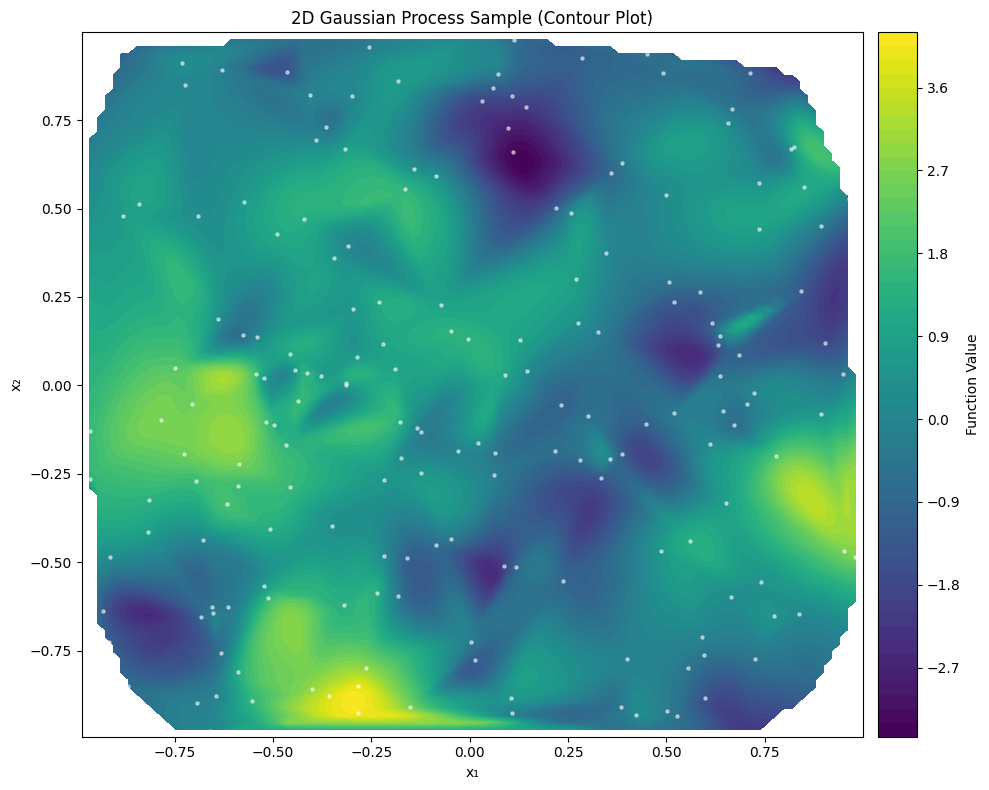

In [4]:
# --- Plot the Generated Data ---
print("Plotting the generated Gaussian Process data...")

from scipy.interpolate import griddata

# Determine the dimensionality of the data
d = x.shape[1]

if d == 1:
    # 1D plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x.cpu().numpy(), y.cpu().numpy(), alpha=0.7, s=10)
    plt.title('1D Gaussian Process Sample')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

elif d == 2:
    # 2D contour plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [1, 0.05]})
    
    # Extract coordinates
    x1, x2 = x[:, 0].cpu().numpy(), x[:, 1].cpu().numpy()
    y_values = y.cpu().numpy()
    
    # Create a regular grid for interpolation
    grid_size = 100
    x1_grid = np.linspace(x1.min(), x1.max(), grid_size)
    x2_grid = np.linspace(x2.min(), x2.max(), grid_size)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)
    
    # Interpolate the scattered data onto the regular grid
    Y_grid = griddata((x1, x2), y_values, (X1, X2), method='cubic')
    
    # Create contour plot
    contour = ax[0].contourf(X1, X2, Y_grid, 50, cmap='viridis')
    ax[0].scatter(x1, x2, c='white', s=5, alpha=0.5)
    ax[0].set_title('2D Gaussian Process Sample (Contour Plot)')
    ax[0].set_xlabel('x₁')
    ax[0].set_ylabel('x₂')
    
    # Add colorbar
    plt.colorbar(contour, cax=ax[1], label='Function Value')
    
    plt.tight_layout()
    plt.show()

elif d == 3:
    # 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract coordinates
    x1, x2, x3 = x[:, 0].cpu().numpy(), x[:, 1].cpu().numpy(), x[:, 2].cpu().numpy()
    y_values = y.cpu().numpy()
    
    # Create scatter plot with color representing the function value
    scatter = ax.scatter(
        x1, x2, x3, 
        c=y_values, 
        cmap='viridis', 
        s=30, 
        alpha=0.8
    )
    
    plt.colorbar(scatter, ax=ax, label='Function Value')
    ax.set_title('3D Gaussian Process Sample')
    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')
    ax.set_zlabel('x₃')
    plt.tight_layout()
    plt.show()

else:
    print(f"Cannot visualize data in {d} dimensions directly.")
    
    # For higher dimensions, we can show pairwise relationships
    if d > 3:
        print("Showing pairwise relationships for the first 3 dimensions:")
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot first 3 dimensions against the function value
        for i in range(min(3, d)):
            scatter = axs[i].scatter(
                x[:, i].cpu().numpy(), 
                y.cpu().numpy(), 
                alpha=0.7, 
                s=10, 
                c=y.cpu().numpy(), 
                cmap='viridis'
            )
            axs[i].set_xlabel(f'x_{i+1}')
            axs[i].set_ylabel('Function Value')
            axs[i].grid(True)
            
        plt.colorbar(scatter, ax=axs)
        plt.tight_layout()
        plt.show()


In [5]:

kernel = SquaredExponential(dimension=d, lengthscale=torch.tensor([true_length_scale]), variance=torch.tensor(true_variance))
init_kernel = kernel


# EFGP setup

In [6]:
# Determine problem geometry
# max and min of each dimension
# updated L according to how it's calculated in philip's code
x_all = torch.cat((x, x_new), dim=0)
# x_all = x
x0 = x_all.min(dim=0).values  
x1 = x_all.max(dim=0).values  

domain_lengths = x1 - x0
L = domain_lengths.max()
N = x.shape[0]
EPSILON = 1e-4
xis_1d, h, mtot = get_xis(kernel_obj=kernel, eps=EPSILON, L=L, use_integral=True, l2scaled=False)
print(xis_1d.shape)
grids = torch.meshgrid(*(xis_1d for _ in range(d)), indexing='ij') # makes tensor product Jm 
xis = torch.stack(grids, dim=-1).view(-1, d) 
print(xis.shape)
ws = torch.sqrt(kernel.spectral_density(xis).to(dtype=torch.complex128) * h**d) # (mtot**d,1)


torch.Size([23])
torch.Size([529, 2])


# Directly checking that 
1) DFF*D approximates K, 
2) matches nufft calculation with higher dim data

In [7]:
ws = ws.to(dtype=torch.complex128)
D = torch.diag(ws).to(dtype=torch.complex128) # (mtot**d, mtot**d)
F = torch.exp(1j * 2 * torch.pi * (x @ xis.T))
F = F.to(dtype=torch.complex128)
A = D @ (torch.conj(F).T @ F) @ D
kernel_approx =  ((F @ torch.diag(ws)) @ (torch.diag(ws) @ torch.conj(F).T))


In [8]:
# get true kernel matrix
kernel_matrix = kernel.kernel_matrix(x, x)


Kernel matrix and kernel approx are close at epsilon: 0.0001


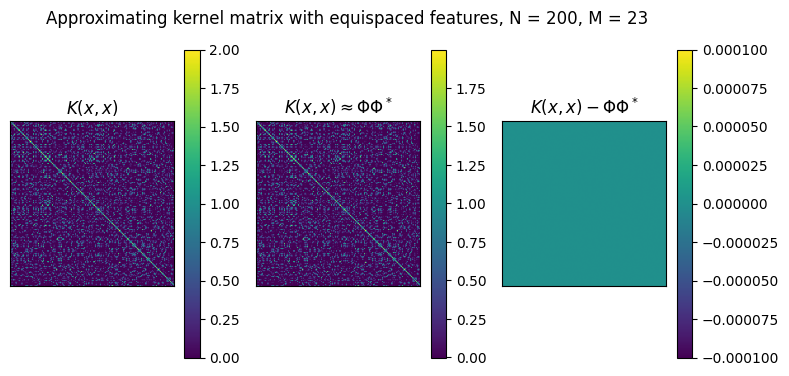

In [9]:
# subplot kernel matrix, kernel approx, and difference side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))

im1 = ax1.imshow(kernel_matrix)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$K(x, x)$')
# no axis labels
ax1.set_xticks([])
ax1.set_yticks([])

im2 = ax2.imshow(kernel_approx.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$K(x, x) \approx \Phi \Phi^*$')
ax2.set_xticks([])
ax2.set_yticks([])

diff = kernel_matrix - kernel_approx.real
im3 = ax3.imshow(diff)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r'$K(x, x) - \Phi \Phi^*$')
ax3.set_xticks([])
ax3.set_yticks([])

plt.suptitle(f'Approximating kernel matrix with equispaced features, N = {N}, M = {mtot}')
# Get the maximum absolute value in the difference matrix for colorbar limits
# Set the color limits to be symmetric around zero, bounded by epsilon
im3.set_clim(-EPSILON, EPSILON)

assert torch.allclose(kernel_matrix, kernel_approx.real, atol=EPSILON)
print(f"Kernel matrix and kernel approx are close at epsilon: {EPSILON}")



# NUFFT checks
- Make sure that $y \mapsto F^* y$ to $y$ and $\beta \mapsto F\beta$ are all close to the NUFFT calculations

In [10]:


device = x.device
rdtype = torch.float64
cdtype = torch.complex128
OUT    = (mtot,) * d                     # NUFFT output shape

# 1) Cast to double and move to device
x = x.to(device, rdtype)
y = y.to(device, rdtype)

N, d = x.shape

# 2) Single‐dimensional quadrature (shared across dims)
#    Use the maximal span among the d coordinates
span   = (x.max(dim=0).values - x.min(dim=0).values).max().item()

xcen = torch.zeros(d, device=device, dtype=rdtype)
phi  = 2 * math.pi * h * (x - xcen)     # (N, d)
phi  = phi.T.contiguous()               # (d, N) for finufft

# 5) NUFFT wrappers (torch‑native, CMCL order)
nufft_eps = 1e-15

def finufft1(vals):
    """
    Adjoint NUFFT: nonuniform→uniform.
    vals: (N,) complex
    returns: tensor of shape OUT, then flattened
    """
    arr = pff.finufft_type1(
        phi, vals.to(cdtype), OUT,
        eps=nufft_eps, isign=-1, modeord=False
    )
    return arr.reshape(-1)  # (mtot**d,)

def finufft2(fk_flat):
    """
    Forward NUFFT: uniform→nonuniform.
    fk_flat: (mtot**d,) complex, in CMCL order
    returns: tensor of shape (N,)
    """
    fk_nd = fk_flat.reshape(OUT)
    return pff.finufft_type2(
        phi, fk_nd.to(cdtype),
        eps=nufft_eps, isign=+1, modeord=False
    )

# 6) Sanity checks:

# (a)  F* y  via NUFFT
fadj_y_nufft = finufft1(y)
fadj_y_nufft_ref = F.conj().T@y.to(dtype=torch.complex128)

# (b)  F  ws_nd  via NUFFT
f_ws_nufft  = finufft2(ws)

f_ws_nufft_ref = F@ws
print(f"Max Relative Error in F^*@y: {((fadj_y_nufft - fadj_y_nufft_ref)/fadj_y_nufft_ref).abs().max()}")
print(f"Max Relative Error in F@ws: {((f_ws_nufft - f_ws_nufft_ref)/f_ws_nufft_ref).abs().max()}")
assert torch.allclose(fadj_y_nufft, fadj_y_nufft_ref)
assert torch.allclose(f_ws_nufft, f_ws_nufft_ref)
print(f"Multi‑D NUFFT adjoint/forward check passed for OUT={OUT}")


Max Relative Error in F^*@y: 7.028514160822596e-14
Max Relative Error in F@ws: 3.893755002746229e-08
Multi‑D NUFFT adjoint/forward check passed for OUT=(23, 23)


In [11]:
import torch, math
m = mtot//2 -1 



# Toeplitz checks

In [12]:
# compute exp(2pi i <xi, x>)
ks = torch.stack(torch.meshgrid(*([torch.arange(-2*m,2*m+1) for _ in range(d)]), indexing='ij'), dim=-1).reshape(-1, d)
vtest = compute_convolution_vector_vectorized_dD(m,x,h)

v_true = torch.exp(-2*math.pi*1j* (x @ (h*ks).T)).sum(dim=0)
assert torch.allclose(vtest.flatten(), v_true, atol=1e-4)

In [13]:
m    = (mtot - 1)//2  
vtest = compute_convolution_vector_vectorized_dD(m, x, h)
toeplitz2d = ToeplitzND(vtest)
beta_flat = torch.randn(mtot**d, dtype=torch.complex128, device=device)
out_flat  = toeplitz2d(beta_flat)    

In [14]:
assert torch.allclose(toeplitz2d(beta_flat), (F.conj().T@F)@ beta_flat)
print(f"ToeplitzND (FFT to apply F^*F) agrees with matrix multiplication")

ToeplitzND (FFT to apply F^*F) agrees with matrix multiplication


# Posterior mean, variance for GP with $x\in \mathbb R^{n\times d}$

In [15]:
x0 = x.min(dim=0).values  
x1 = x.max(dim=0).values  


In [16]:
cg_tol = 1e-4
J = 1000

model = EFGPND(
    x        = x,               # training inputs
    y        = y,               # training targets
    kernel   = kernel,
    sigmasq  = sigmasq,
    eps      = EPSILON,
    nufft_eps = 1e-10,
    opts     = {
        "cg_tolerance"     : cg_tol,
        "early_stopping"   : True,
    },
)



# Optimizing hyperparameters 

In [17]:
x0 = x.min(dim=0).values  
x1 = x.max(dim=0).values  
model = EFGPND(x, y, kernel, sigmasq, EPSILON, nufft_eps=1e-10).optimize_hyperparameters(
    epsilon_values       = [1e-2],
    trace_samples_values = [10],
    lr                   = 0.01,
    max_iters            = 50,
    x0 = x0, x1 = x1,                    
)

# now, training_log contains per‑iteration traces
model.fit()                              # build posterior with new θ


[ε=0.01 | J=10] iter   0  ℓ=0.2466  σ_f²=1.889  σ_n²=0.166
grad: tensor([ -30.3224,    2.8535, -506.9340], dtype=torch.float64)
[ε=0.01 | J=10] iter  10  ℓ=0.2614  σ_f²=1.148  σ_n²=0.1989
grad: tensor([-477.5434,   14.4907,   46.6792], dtype=torch.float64)
[ε=0.01 | J=10] iter  20  ℓ=0.2932  σ_f²=1.201  σ_n²=0.1931
grad: tensor([-244.8639,    6.4210,   34.4042], dtype=torch.float64)
[ε=0.01 | J=10] iter  30  ℓ=0.256  σ_f²=1.155  σ_n²=0.199
grad: tensor([-500.5046,   15.1667,   46.5957], dtype=torch.float64)
[ε=0.01 | J=10] iter  40  ℓ=0.2802  σ_f²=1.214  σ_n²=0.1912
grad: tensor([-195.1614,    4.2640,   36.6926], dtype=torch.float64)
└─ finished ε=0.01, J=10 in 1.8s


# Get posterior mean and variance with various methods
- Using hyperparameters from training

In [18]:
print(f'x_new.shape: {x_new.shape}, hutchinson_probes: {J}')

# Time stochastic variance estimation
start_time = time.time()
beta, xis, ytrg1, ws, toeplitz = efgp_nd(
    x=x,
    y=y,
    sigmasq=sigmasq,
    kernel=kernel,
    eps=EPSILON,
    x_new=x_new,
    nufft_eps=1e-10,
    opts={'cg_tolerance': cg_tol, 'early_stopping': True, 'estimate_variance': True, 'variance_method': 'stochastic', 'hutchinson_probes': J}
)
stochastic_time = time.time() - start_time
print(f"Stochastic variance estimation time: {stochastic_time:.4f} seconds")

# Time regular variance estimation
start_time = time.time()
beta, xis, ytrg2, ws, toeplitz = efgp_nd(
    x=x,
    y=y,
    sigmasq=sigmasq,
    kernel=kernel,
    eps=EPSILON,
    x_new=x_new,
    nufft_eps=1e-10,
    opts={'cg_tolerance': cg_tol, 'estimate_variance': True,
    'variance_method':'regular','early_stopping': True}
)
regular_time = time.time() - start_time
print(f"Regular variance estimation time: {regular_time:.4f} seconds")

# Time default settings
start_time = time.time()
beta, xis, ytrg, ws, toeplitz = efgp_nd(x, y, sigmasq, kernel, EPSILON, x_new, nufft_eps=1e-15)
default_time = time.time() - start_time
print(f"Time for no variance computation (mean only): {default_time:.4f} seconds")

x_new.shape: torch.Size([2500, 2]), hutchinson_probes: 1000
Stochastic variance estimation time: 4.1713 seconds
Regular variance estimation time: 11.1561 seconds
Time for no variance computation (mean only): 0.1208 seconds


In [19]:
beta, xis, ytrg, ws, toeplitz = efgp_nd(
    x=x,
    y=y,
    sigmasq=sigmasq,
    kernel=kernel,
    eps=EPSILON,
    x_new=x_new,
    nufft_eps=1e-10,

    opts={'cg_tolerance': cg_tol, 'estimate_variance': True,
    'variance_method':'regular','early_stopping': True}
)
if d == 2:

    import plotly.graph_objects as go
    import numpy as np
    from scipy.interpolate import griddata

    # --- Prepare Data for Plotting ---
    # Extract x1, x2 coordinates and mean values from tensors
    x1 = x_new[:, 0].cpu().numpy()
    x2 = x_new[:, 1].cpu().numpy()
    mean_values = ytrg['mean'].cpu().numpy()

    # Create a grid for the surface plot
    x1_grid = np.linspace(x1.min(), x1.max(), 100)
    x2_grid = np.linspace(x2.min(), x2.max(), 100)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)

    # Interpolate mean values onto the grid for smooth surface visualization
    mean_surface = griddata(
        points=(x1, x2), 
        values=mean_values, 
        xi=(X1, X2), 
        method='cubic'
    )

    # --- Create Interactive 3D Plot ---
    fig = go.Figure()

    # Add the mean surface with transparency
    fig.add_trace(go.Surface(
        z=mean_surface,
        x=X1,
        y=X2,
        colorscale='Viridis',
        opacity=0.8,  # Adjust transparency for better visualization
        name='EFGP Mean',
        colorbar=dict(
            title=dict(
                text="Mean Value",
                font=dict(size=14)
            ),
            tickfont=dict(size=12)
        )
    ))

    # Add scatter points for the true data
    fig.add_trace(go.Scatter3d(
        x=x[:, 0].cpu().numpy(),
        y=x[:, 1].cpu().numpy(),
        z=y.cpu().numpy(),
        mode='markers',
        marker=dict(
            size=4,  # Smaller scatter points
            color='red',
            opacity=0.9,  # Slight transparency for markers
            symbol='circle'
        ),
        name='True Data'
    ))

    # --- Update Layout for Better Visualization ---
    fig.update_layout(
        scene=dict(
            aspectmode='manual',
            aspectratio=dict(x=1.5, y=1.5, z=1), # Make x and y dimensions wider relative to z
            xaxis=dict(
                title=dict(
                    text='x₁',
                    font=dict(size=16)
                ),
                tickfont=dict(size=12),
                showgrid=True,
                gridcolor='lightgray'
            ),
            yaxis=dict(
                title=dict(
                    text='x₂',
                    font=dict(size=16)
                ),
                tickfont=dict(size=12),
                showgrid=True,
                gridcolor='lightgray'
            ),
            zaxis=dict(
                title=dict(
                    text='Mean/True Data',
                    font=dict(size=16)
                ),
                tickfont=dict(size=12),
                showgrid=True,
                gridcolor='lightgray'
            ),
            camera=dict(
                eye=dict(x=1.25, y=1.25, z=1)  # Adjust camera angle for better view
            )
        ),
        title=dict(
            text='EFGP Mean and True Data',
            font=dict(size=18),
            x=0.5,  # Center the title
            xanchor='center'
        ),
        legend=dict(
            x=0.8,
            y=0.9,
            font=dict(size=12),
            bgcolor='rgba(255, 255, 255, 0.8)',  # Add a semi-transparent background
            bordercolor='black',
            borderwidth=1
        ),
        margin=dict(l=0, r=0, t=50, b=0),  # Reduce margins for a cleaner look
        width=800,  # Increase figure width
        height=600   # Increase figure height
    )

    # Display the plot
    fig.show()




# Stochastic versus regular variance estimates

In [20]:
if d == 1:
    # plot x_new against ytrg['var'] and ytrg2['var']
    plt.plot(x_new.cpu(), ytrg1['var'].cpu(), 'o')
    plt.plot(x_new.cpu(), ytrg2['var'].cpu(), 'o')
    plt.xlabel('x_new')
    plt.ylabel('ytrg["var"]')
    plt.legend(['stochastic', 'regular'])
    plt.show()




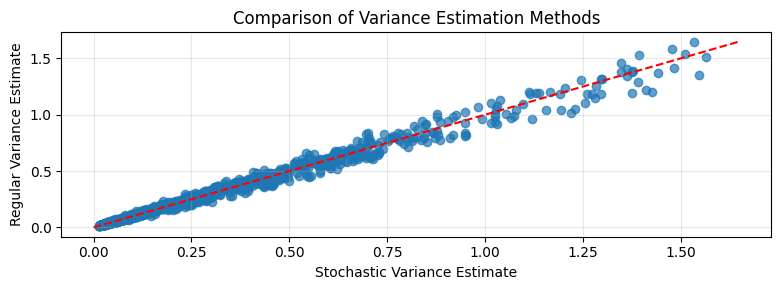

Correlation between stochastic and regular variance estimates: 0.9948


In [21]:
# Create a scatter plot comparing stochastic vs regular variance estimates
plt.figure(figsize=(8, 3))
plt.scatter(ytrg1['var'].cpu(), ytrg2['var'].cpu(), alpha=0.7)
plt.plot([0, ytrg2['var'].cpu().max()], [0, ytrg2['var'].cpu().max()], 'r--')  # Add identity line
plt.xlabel('Stochastic Variance Estimate')
plt.ylabel('Regular Variance Estimate')
plt.title('Comparison of Variance Estimation Methods')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation between the two variance estimates
correlation = torch.corrcoef(torch.stack([ytrg1['var'], ytrg2['var']]))[0, 1]
print(f"Correlation between stochastic and regular variance estimates: {correlation:.4f}")


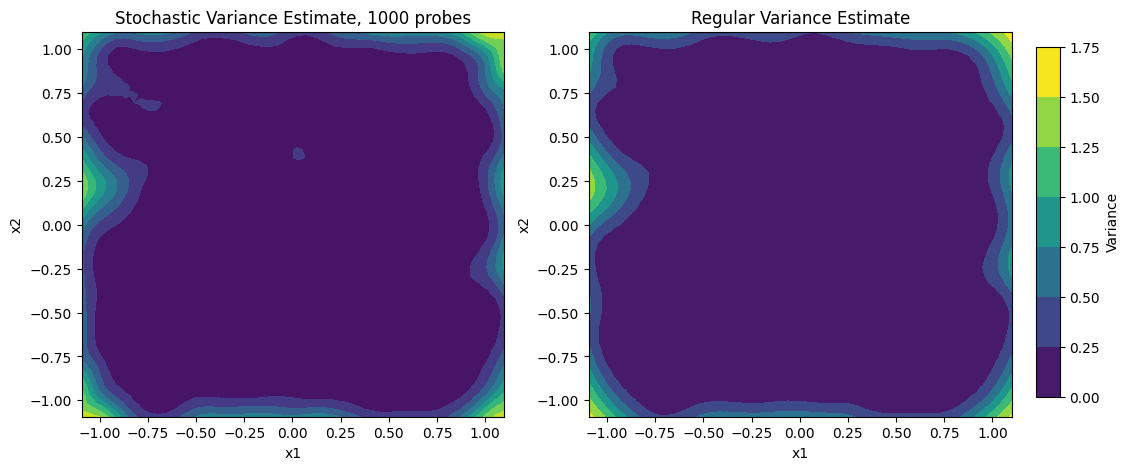

In [22]:
# Check dimensionality and plot accordingly
if x_new.shape[1] > 1:  # For d > 1
    # Create contour plots for variance comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=False)
    
    # Extract coordinates
    x1 = x_new[:, 0].cpu()
    x2 = x_new[:, 1].cpu()
    var1 = ytrg1['var'].cpu()
    var2 = ytrg2['var'].cpu()
    
    # Use regular variance range for both plots
    vmin = var2.min()
    vmax = var2.max()
    
    # Create contour plots with same scale
    sc1 = ax1.tricontourf(x1, x2, var1, cmap='viridis', vmin=vmin, vmax=vmax)
    ax1.set_title(f'Stochastic Variance Estimate, {J} probes')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    
    sc2 = ax2.tricontourf(x1, x2, var2, cmap='viridis', vmin=vmin, vmax=vmax)
    ax2.set_title('Regular Variance Estimate') 
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    
    # Add a single colorbar for both plots with proper positioning
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(sc2, cax=cbar_ax)
    cbar.set_label('Variance')
    
    plt.show()
else:  # For d = 1
    # plot x_new against ytrg['var'] and ytrg2['var']
    plt.plot(x_new.cpu(), ytrg1['var'].cpu(), 'o')
    plt.plot(x_new.cpu(), ytrg2['var'].cpu(), 'o')
    plt.xlabel('x_new')
    plt.ylabel('ytrg["var"]')
    # add a legend
    plt.legend(['stochastic', 'regular'])
    plt.show()


In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Only make a 1D plot when the input dimension is 1
if d == 1:
    # Move tensors to CPU / numpy
    x_np       = x.detach().cpu().numpy().flatten()
    y_np       = y.detach().cpu().numpy().flatten()
    x_new_np   = x_new.detach().cpu().numpy().flatten()
    mean_np    = ytrg['mean'].detach().cpu().numpy().flatten()
    var_np     = ytrg['var'].detach().cpu().numpy().flatten()
    std_np     = np.sqrt(var_np)

    # Sort by x_new so that lines are not jumbled
    sort_idx     = np.argsort(x_new_np)
    x_new_sorted = x_new_np[sort_idx]
    mean_sorted  = mean_np[sort_idx]
    std_sorted   = std_np[sort_idx]

    # Plot data, mean and ±2σ band
    plt.figure(figsize=(10, 6))
    plt.plot(x_np, y_np, 'kx', label='Training Data')
    plt.plot(x_new_sorted, mean_sorted, 'b-', label='Mean Prediction')
    plt.fill_between(
        x_new_sorted,
        mean_sorted - 2 * std_sorted,
        mean_sorted + 2 * std_sorted,
        color='blue',
        alpha=0.2,
        label='95% Confidence Interval on Mean Function'
    )
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('GP Mean Prediction with 95% CI')
    plt.legend()
    plt.show()


# Directly calculating posterior variance and mean to check

In [24]:
N, d = x.shape
B = x_new.shape[0]
M = xis.shape[0]

x = x.to(device, rdtype)
y = y.to(device, rdtype)
x_new = x_new.to(device, rdtype)
xis = xis.to(device, rdtype)
ws = ws.to(device, cdtype)
sigmasq = torch.tensor(sigmasq, device=device, dtype=rdtype)

F_train = torch.exp(2 * math.pi * 1j * torch.matmul(x, xis.T)).to(cdtype)
F_new = torch.exp(2 * math.pi * 1j * torch.matmul(x_new, xis.T)).to(cdtype)

W_F_train_star = ws.unsqueeze(1) * F_train.conj().T

K_train = (F_train * ws) @ W_F_train_star
K_new_train = (F_new * ws) @ W_F_train_star
diag_K_new_new = torch.sum(torch.abs(F_new * ws)**2, dim=1)

I_N = torch.eye(N, device=device, dtype=rdtype)
K_plus_noise = K_train + sigmasq * I_N
if K_plus_noise.dtype != cdtype:
    K_plus_noise = K_plus_noise.to(cdtype)

y_c = y.to(cdtype)
try:
    z = torch.linalg.solve(K_plus_noise, y_c)
except torch.linalg.LinAlgError:
    z = torch.full_like(y_c, float('nan'))

yhat_direct = (K_new_train @ z).real

K_new_train_conj_T = K_new_train.conj().T
try:
    Z = torch.linalg.solve(K_plus_noise, K_new_train_conj_T)
except torch.linalg.LinAlgError:
    Z = torch.full((N, B), float('nan'), device=device, dtype=cdtype)

var_reduction_diag = torch.sum(K_new_train * Z.T, dim=1)
variance_direct = diag_K_new_new - var_reduction_diag.real
variance_direct = torch.clamp(variance_direct, min=0.0)


/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_91480/1467099095.py:10: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [25]:
assert torch.allclose(ytrg['mean'], yhat_direct, atol=1e-4)
print("ytrg['mean'] (EFGP mean) and yhat_direct (direct computation using the same approximations, no tricks) are close")
# if variance exists
if 'var' in ytrg:
    # Check variance
    assert torch.allclose(ytrg2['var'], variance_direct, atol=1e-4)
    print("ytrg2['var'] (non-stochastic variance estimate) and variance_direct are close")


ytrg['mean'] (EFGP mean) and yhat_direct (direct computation using the same approximations, no tricks) are close
ytrg2['var'] (non-stochastic variance estimate) and variance_direct are close


# Showing estimation of $c[\vec{r}]$ using Hutchinson probes
- Compare to direct computation of sums of "diagonal" offsets
- See paper

In [26]:
ns_shape = tuple(toeplitz.ns)

ws_block_view = ws.view(1, *ns_shape)

# Operator for variance: A_var = D T D / sigmasq + I
# This operator is equivalent to 'A' in the working snippet
def A_var_apply(gamma_in: torch.Tensor) -> torch.Tensor:
    is_batch = gamma_in.ndim > 1
    if not gamma_in.is_complex(): gamma_in = gamma_in.to(dtype=cdtype)
    B_dim = gamma_in.shape[0] if is_batch else 1
    in_shape = (B_dim, *ns_shape) if is_batch else (1, *ns_shape)
    out_shape = (B_dim, M) if is_batch else (M,)

    gamma_in_block = gamma_in.view(in_shape)
    w_gamma_block = ws_block_view * gamma_in_block # Apply D
    T_W_gamma_block = toeplitz(w_gamma_block)      # Apply T = F^H F
    result_block = ws_block_view * T_W_gamma_block # Apply D
    result_block = result_block / sigmasq   # Divide by sigma^2
    result_flat = result_block.view(out_shape)     # Reshape back
    result_flat = torch.add(result_flat, gamma_in, alpha=1.0) # Add Identity term
    return result_flat

In [27]:
# copy pasted from efgpnd.py
eps = EPSILON
x_all = torch.cat((x,x_new), dim=0)
L     = torch.max(torch.max(x_all, dim=0).values - torch.min(x_all, dim=0).values)
if L <= 1e-9:
    L = torch.tensor(1.0, device=device, dtype=rdtype)
xis_1d, h_float, mtot = get_xis(kernel_obj=kernel, eps=eps, L=L.item(), use_integral=True, l2scaled=False)
h         = torch.tensor(h_float, device=device, dtype=rdtype)
xis_1d    = xis_1d.to(device=device, dtype=rdtype)
grids     = torch.meshgrid(*(xis_1d for _ in range(d)), indexing="ij")
xis       = torch.stack(grids, dim=-1).view(-1, d)            # (M, d)
M         = xis.shape[0]
spectral_vals = kernel.spectral_density(xis).to(dtype=cdtype)
ws        = torch.sqrt(spectral_vals * (h ** d))               # (M,)
max_cg_iter = 100
m_conv       = (mtot - 1) // 2
v_kernel     = compute_convolution_vector_vectorized_dD(m_conv, x, h).to(dtype=cdtype)
toeplitz     = ToeplitzND(v_kernel, force_pow2=True)
ns_shape     = tuple(toeplitz.ns)
ws_block     = ws.view(1, *ns_shape)
sigmasq_scalar = sigmasq.item()
def A_var(gamma):
    is_batch   = gamma.ndim > 1
    gamma      = gamma.to(dtype=cdtype)
    shape_in   = (gamma.shape[0], *ns_shape) if is_batch else (1, *ns_shape)
    g_block    = gamma.view(shape_in)
    Tg         = toeplitz(ws_block * g_block)
    out_block  = ws_block * Tg / sigmasq_scalar + g_block
    return out_block.view(gamma.shape)

est_sums_grid_og = diag_sums_nd(
    A_var,
    J,
    xis,
    max_cg_iter,
    cg_tol,
    ws
)

max abs err: 0.03600391063219587
rmse:       0.004186592657007921


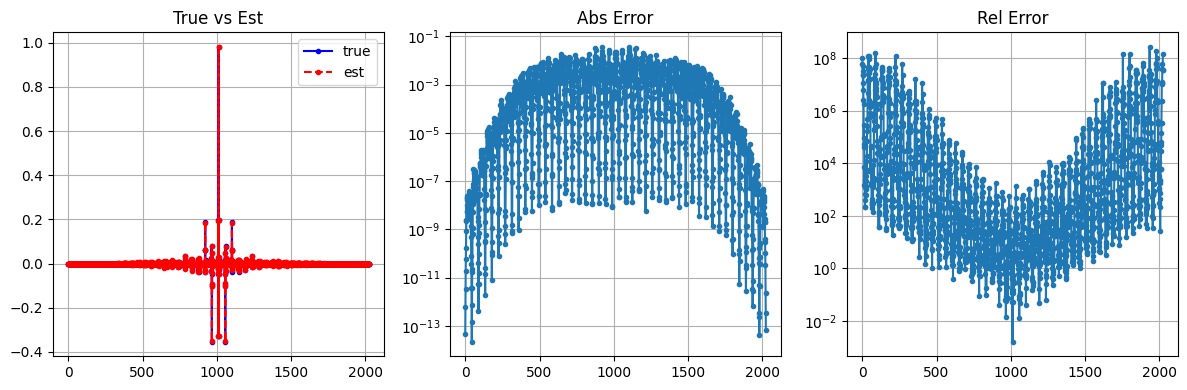

In [28]:
# calculate the true sums and compare

# 2) shift so that (0,…,0) lives at the center (M-1,…,M-1)
N, d = xis.shape
M     = round(N ** (1/d))   # = 2*m+1
m     = (M - 1) // 2        # M = 2*m+1
shifts = (M-1,)*d
dims   = tuple(range(d))
est_sums_grid = est_sums_grid_og.roll(shifts=shifts, dims=dims)

# 3) flatten to compare with true_sums
est_sums = est_sums_grid.flatten()

F_conj_T = F_train.conj().T
I_M = torch.eye(xis.shape[0], xis.shape[0])
D = torch.diag(ws)
D_inv = torch.diag(1.0 / torch.diag(D))
A = (D @ F_conj_T @ F_train @ D) / sigmasq + I_M

C0 = D_inv @ A @ D_inv
Cinv = torch.linalg.inv(C0)
true_grid = torch.zeros(est_sums_grid_og.shape, device=Cinv.device, dtype=Cinv.dtype)
k_grid    = (xis/h).round().long()

# Get the grid dimensions to avoid index out of bounds
grid_shape = true_grid.shape
grid_dims = [dim_size for dim_size in grid_shape]

for j in range(N):
    kj = k_grid[j]
    for ℓ in range(N):
        r = (k_grid[ℓ] - kj).tolist()
        # Check if indices are within bounds before adding
        idx = []
        valid_idx = True
        for dim_idx, ri in enumerate(r):
            idx_val = ri + 2*m
            if idx_val < 0 or idx_val >= grid_dims[dim_idx]:
                valid_idx = False
                break
            idx.append(idx_val)
        
        if valid_idx:
            true_grid[tuple(idx)] += Cinv[j, ℓ]

true_sums = true_grid.flatten()


# -----------------------------------------------------------------------------
# 5) error, printing, plotting
# -----------------------------------------------------------------------------
err   = est_sums - true_sums
rel   = err / true_sums
x_ax  = torch.arange(true_sums.numel()).cpu().numpy()

print("max abs err:", err.abs().max().item())
print("rmse:      ", torch.sqrt((err.abs()**2).mean()).item())

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(x_ax, true_sums.real.cpu(), 'b.-', label="true")
plt.plot(x_ax, est_sums.real.cpu(), 'r.--', label="est")
plt.legend(); plt.grid(True); plt.title("True vs Est")

plt.subplot(1,3,2)
plt.plot(x_ax, err.abs().cpu(), '.-')
plt.yscale('log'); plt.title("Abs Error"); plt.grid(True)

plt.subplot(1,3,3)
plt.plot(x_ax, rel.abs().cpu(), '.-')
plt.yscale('log'); plt.title("Rel Error"); plt.grid(True)

plt.tight_layout()
plt.show()


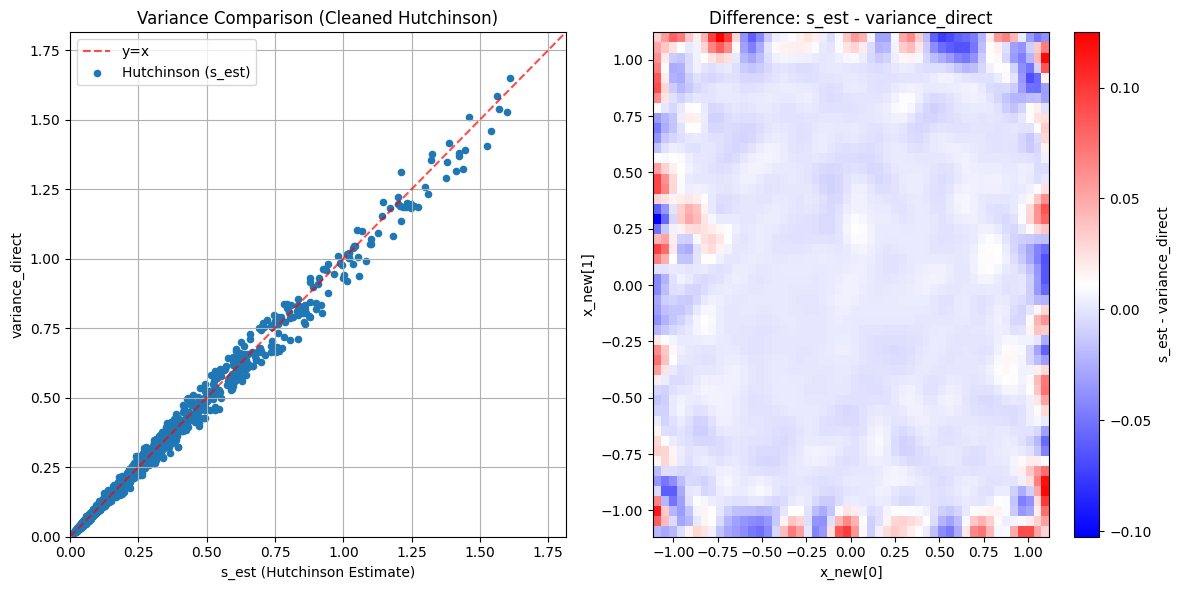

In [29]:

s_est = nufft_var_est_nd(est_sums_grid_og,h,xcen,x_new,nufft_eps)
# s_est = nufft_var_est(est_sums,h,xcen,nufft_eps)

all_vals = torch.cat((s_est.cpu(), variance_direct.cpu())).numpy()
min_val = min(0, all_vals.min()) * 1.1
max_val = max(0, all_vals.max()) * 1.1
lims = [min_val, max_val]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(lims, lims, 'r--', alpha=0.7, label='y=x')
plt.scatter(s_est.cpu().numpy(), variance_direct.cpu().numpy(), label="Hutchinson (s_est)", s=20)
plt.xlabel("s_est (Hutchinson Estimate)")
plt.ylabel("variance_direct")
plt.title("Variance Comparison (Cleaned Hutchinson)")
plt.legend()
plt.grid(True)
plt.xlim(lims)
plt.ylim(lims)

if d == 1:
    x_new_1d = x_new.flatten()
    plt.subplot(1, 2, 2)
    plt.plot(x_new_1d.cpu().numpy(), s_est.cpu().numpy(), 'b.-', label='s_est (Hutchinson)')
    plt.plot(x_new_1d.cpu().numpy(), variance_direct.cpu().numpy(), 'r.-', label='variance_direct')
    plt.xlabel("x_new")
    plt.ylabel("Variance")
    plt.title("Variance Estimates vs. Position")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
elif d == 2:
    # Compute the difference between s_est and variance_direct
    diff = (s_est - variance_direct).cpu().numpy()
    # Assume x_new is (B, 2) and forms a grid
    x = x_new[:, 0].cpu().numpy()
    y = x_new[:, 1].cpu().numpy()
    # Try to infer grid shape
    B = x_new.shape[0]
    n = int(np.sqrt(B))
    if n * n == B:
        X = x.reshape(n, n)
        Y = y.reshape(n, n)
        Z = diff.reshape(n, n)
        plt.subplot(1, 2, 2)
        im = plt.pcolormesh(X, Y, Z, shading='auto', cmap='bwr')
        plt.colorbar(im, label="s_est - variance_direct")
        plt.xlabel("x_new[0]")
        plt.ylabel("x_new[1]")
        plt.title("Difference: s_est - variance_direct")
        plt.tight_layout()
        plt.show()
    else:
        # fallback: scatter plot if not a grid
        plt.subplot(1, 2, 2)
        sc = plt.scatter(x, y, c=diff, cmap='bwr')
        plt.colorbar(sc, label="s_est - variance_direct")
        plt.xlabel("x_new[0]")
        plt.ylabel("x_new[1]")
        plt.title("Difference: s_est - variance_direct")
        plt.tight_layout()
        plt.show()


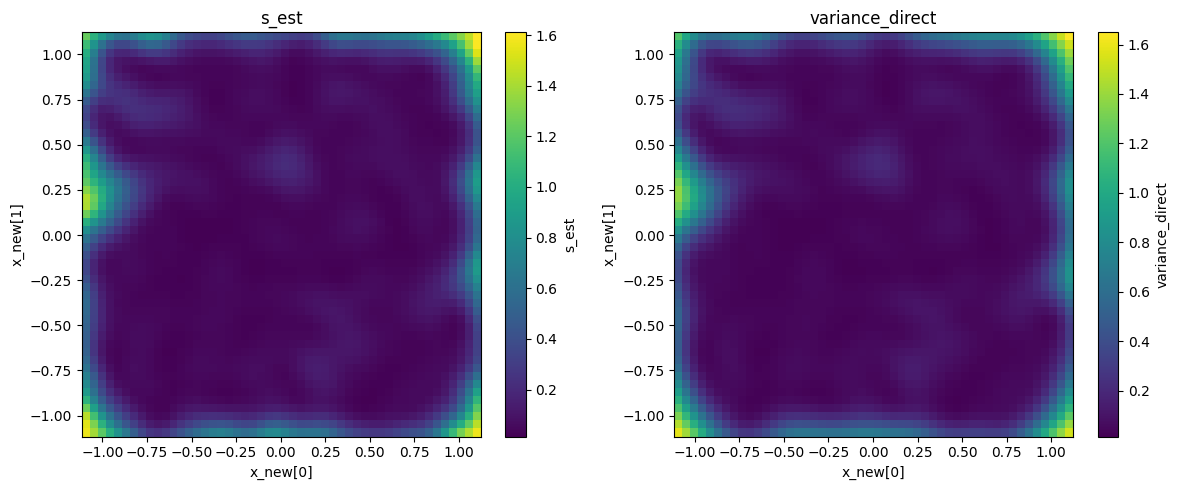

In [30]:
if d == 2:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    # Assume x_new is (B, 2) and forms a grid
    x = x_new[:, 0].cpu().numpy()
    y = x_new[:, 1].cpu().numpy()
    B = x_new.shape[0]
    n = int(np.sqrt(B))
    if n * n == B:
        X = x.reshape(n, n)
        Y = y.reshape(n, n)
        Z1 = s_est.cpu().numpy().reshape(n, n)
        Z2 = variance_direct.cpu().numpy().reshape(n, n)
        im1 = axs[0].pcolormesh(X, Y, Z1, shading='auto', cmap='viridis')
        fig.colorbar(im1, ax=axs[0], label="s_est")
        axs[0].set_title("s_est")
        axs[0].set_xlabel("x_new[0]")
        axs[0].set_ylabel("x_new[1]")
        im2 = axs[1].pcolormesh(X, Y, Z2, shading='auto', cmap='viridis')
        fig.colorbar(im2, ax=axs[1], label="variance_direct")
        axs[1].set_title("variance_direct")
        axs[1].set_xlabel("x_new[0]")
        axs[1].set_ylabel("x_new[1]")
    else:
        sc1 = axs[0].scatter(x, y, c=s_est.cpu().numpy(), cmap='viridis')
        fig.colorbar(sc1, ax=axs[0], label="s_est")
        axs[0].set_title("s_est")
        axs[0].set_xlabel("x_new[0]")
        axs[0].set_ylabel("x_new[1]")
        sc2 = axs[1].scatter(x, y, c=variance_direct.cpu().numpy(), cmap='viridis')
        fig.colorbar(sc2, ax=axs[1], label="variance_direct")
        axs[1].set_title("variance_direct")
        axs[1].set_xlabel("x_new[0]")
        axs[1].set_ylabel("x_new[1]")
    plt.tight_layout()
    plt.show()
